In [1]:
!pip install nltk wordcloud spacy --quiet
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import spacy
spacy.cli.download("en_core_web_sm")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
train = pd.read_csv(r'/content/drugsComTest_raw.csv')
test = pd.read_csv(r'/content/drugsComTest_raw.csv')
print(train.shape, test.shape)
print(train.info())
print(train.head())

(53766, 7) (53766, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53766 entries, 0 to 53765
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   uniqueID     53766 non-null  int64 
 1   drugName     53766 non-null  object
 2   condition    53471 non-null  object
 3   review       53766 non-null  object
 4   rating       53766 non-null  int64 
 5   date         53766 non-null  object
 6   usefulCount  53766 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 2.9+ MB
None
   uniqueID         drugName                     condition  \
0    163740      Mirtazapine                    Depression   
1    206473       Mesalamine  Crohn's Disease, Maintenance   
2    159672          Bactrim       Urinary Tract Infection   
3     39293         Contrave                   Weight Loss   
4     97768  Cyclafem 1 / 35                 Birth Control   

                                              review  rating       date  

In [4]:
# Data Preprocessing & Cleaning
print(train.isnull().sum())
train = train.dropna(subset=['review', 'condition'])
train = train.drop_duplicates()
print(train.isnull().sum())

uniqueID         0
drugName         0
condition      295
review           0
rating           0
date             0
usefulCount      0
dtype: int64
uniqueID       0
drugName       0
condition      0
review         0
rating         0
date           0
usefulCount    0
dtype: int64


In [5]:
# Outlier handling for rating and usefulCount (Optional)
train = train[(train['rating']>=1) & (train['rating']<=10)]  # Keep only valid ratings

In [6]:
# NLP Preprocessing Pipeline
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [8]:
import nltk
nltk.download('punkt_tab')
def clean_review(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)  # Remove punctuation and numbers
    tokens = word_tokenize(text)
    tokens = [w for w in tokens if w not in stop_words]
    tokens = [lemmatizer.lemmatize(w) for w in tokens]
    return " ".join(tokens)

train['clean_review'] = train['review'].map(clean_review)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


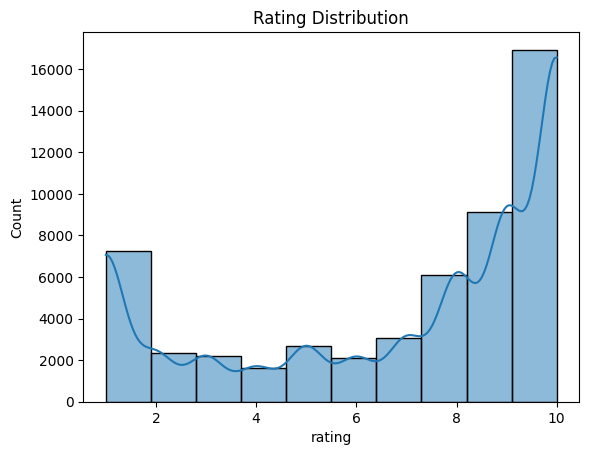

In [9]:
# Exploratory Data Analysis (EDA)
# Rating distribution
sns.histplot(train['rating'], bins=10, kde=True)
plt.title('Rating Distribution')
plt.show()

In [10]:
# Most common drugs/conditions
print(train['drugName'].value_counts().head())
print(train['condition'].value_counts().head())

drugName
Levonorgestrel                       1265
Etonogestrel                         1081
Ethinyl estradiol / norethindrone     869
Nexplanon                             736
Ethinyl estradiol / norgestimate      649
Name: count, dtype: int64
condition
Birth Control    9648
Depression       3095
Pain             2100
Anxiety          1908
Acne             1847
Name: count, dtype: int64


In [11]:
# Average review length
train['review_len'] = train['clean_review'].apply(lambda x: len(x.split()))
print(train['review_len'].describe())

count    53471.000000
mean        41.357053
std         21.651262
min          0.000000
25%         24.000000
50%         41.000000
75%         61.000000
max        533.000000
Name: review_len, dtype: float64


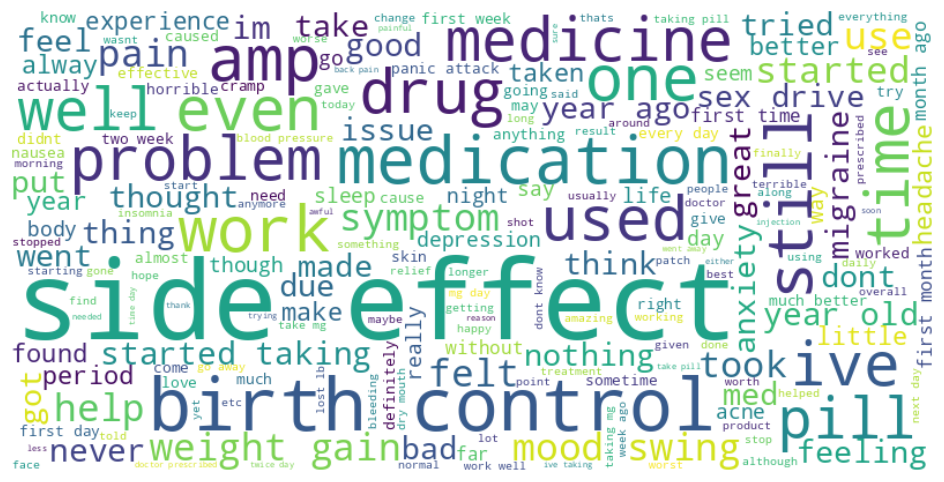

In [12]:
# WordCloud for reviews
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(train['clean_review']))
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [13]:
# Sentiment Analysis Prep: map ratings to sentiment
def map_sentiment(rating):
    if rating >= 8:
        return 'positive'
    elif rating <= 3:
        return 'negative'
    else:
        return 'neutral'

train['sentiment'] = train['rating'].map(map_sentiment)
print(train['sentiment'].value_counts())

sentiment
positive    32175
negative    11786
neutral      9510
Name: count, dtype: int64


In [14]:

# Training a Baseline Classifier (Logistic Regression with TF-IDF)
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(train['clean_review'])
y = train['sentiment']

X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
clf = LogisticRegression(max_iter=200)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)

In [15]:
print("Classification report:\n", classification_report(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))

Classification report:
               precision    recall  f1-score   support

    negative       0.67      0.62      0.64      2357
     neutral       0.46      0.22      0.30      1902
    positive       0.77      0.91      0.84      6436

    accuracy                           0.72     10695
   macro avg       0.63      0.58      0.59     10695
weighted avg       0.69      0.72      0.70     10695

Confusion Matrix:
 [[1460  235  662]
 [ 415  414 1073]
 [ 316  248 5872]]


MediGenBot

In [16]:
!pip install transformers faiss-cpu torch --quiet

import torch
from transformers import BertTokenizer, BertModel, pipeline
import faiss
import numpy as np
import pandas as pd


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 35.9 MB/s eta 0:00:00


In [17]:
train = pd.read_csv('/content/drugsComTrain_raw.csv')


In [18]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

def get_bert_embedding(text):
    inputs = bert_tokenizer(text, return_tensors='pt', truncation=True, max_length=512, padding=True)
    outputs = bert_model(**inputs)
    embeddings = outputs.last_hidden_state  # (batch_size, seq_len, hidden_size)
    attention_mask = inputs['attention_mask']
    mask_expanded = attention_mask.unsqueeze(-1).expand(embeddings.size()).float()
    sum_embeddings = torch.sum(embeddings * mask_expanded, 1)
    sum_mask = torch.clamp(mask_expanded.sum(1), min=1e-9)
    mean_pooled = sum_embeddings / sum_mask
    return mean_pooled.detach().numpy()[0]

# Compute embeddings for first 1000 reviews (can scale up as needed)
subset_reviews = train['review'].dropna().head(1000).tolist()
embeddings = np.array([get_bert_embedding(r) for r in subset_reviews])


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [19]:
embedding_dim = embeddings.shape[1]
index = faiss.IndexFlatL2(embedding_dim)
index.add(embeddings)

# Example Query
query = "I need a drug for blood pressure"
query_vec = get_bert_embedding(query)[None, :]
k = 5  # Number of similar reviews to retrieve
D, I = index.search(query_vec, k)

print("Most similar reviews:")
for idx in I[0]:
    print(train['review'].iloc[idx])
    print("---")


Most similar reviews:
"52 hrs old, I started taking Flomax for BPH. It completely blocked my sinus. So I asked for something different. My urologist prescribed Rapaflo, but they blocked sinus was even worse and it cost me 260.00 for 30 pills! Horrible medicine! Avoid at all costs."
---
"I started on liquid Prozac due to severe medicine sensitivities.  This has been a lifesaver.  I am currently on 2.5 mg and feel so much better.  My doctor would like me to get to 5mg, I will, but it will be slowly.  There is no one size fits all as far as dosage goes.  If you&#039;re sensitive to medicines, think about liquid Prozac.  Easier to control dosages, minimal side effects.  Wonderful!"
---
"This medicine is great for daytime anxiety or anxiety with insomnia. Doctors give way too much of this 300mg, 500mg, etc. to non-manic patients when much smaller dosages will work. I used a HALF TABLET (12.5mg) for sleep. Lately I used 1/4 tablet (one in morning and one in afternoon) to lower base anxiety l

In [20]:
gpt_pipe = pipeline("text-generation", model="gpt2", tokenizer="gpt2")
prompt = "Based on symptoms of high blood pressure, suggest a drug"
response = gpt_pipe(prompt, max_length=50, num_return_sequences=1)
print("GPT response:", response[0]['generated_text'])


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


GPT response: Based on symptoms of high blood pressure, suggest a drug that can block the effects of high blood pressure.

A patient with elevated blood pressure who took a drug with a high blood pressure can be at increased risk for developing high blood pressure, according to the American Heart Association.

The heart rate monitor, which is attached to a heart rate monitor, detects abnormal heart rhythm, or normal heart rhythms.

The blood pressure monitor has a blood pressure sensor that monitors the blood pressure of the heart. The blood pressure sensor detects blood flow and the heart rate monitor records the heart rate.

The blood pressure monitor has a sensor that monitors the blood pressure of the heart. The blood pressure sensor detects blood flow and the heart rate monitor records the heart rate.

The heart rate monitor has a sensor that monitors the heart rate of the heart. The heart rate sensor detects blood flow and the heart rate monitor records the heart rate.

The patie

In [21]:
# 1. Retrieve top-k similar reviews
D, I = index.search(query_vec, k=5)
retrieved_texts = [train['review'].iloc[idx] for idx in I[0]]

# 2. Construct augmented prompt for generation
retrieved_context = "\n\n".join(retrieved_texts)
prompt = f"""Given the following context from patient reviews:
{retrieved_context}

Patient's query: {user_query}
Based on the above, provide a drug recommendation with clear reasoning.
"""

# 3. Generate response with GPT model
output = gpt_pipe(prompt, max_length=200, num_return_sequences=1)
print("Bot:", output[0]['generated_text'])


NameError: name 'user_query' is not defined

In [22]:
# Step 1: Set the patient's question or query
user_query = "I have high blood pressure. What drug do you recommend?"

# Step 2: Get the embedding of the user's query
query_vec = get_bert_embedding(user_query)[None, :]

# Step 3: Retrieve top-k similar reviews
D, I = index.search(query_vec, k=5)
retrieved_texts = [train['review'].iloc[idx] for idx in I[0]]

# Step 4: Construct the augmented prompt for the LLM
retrieved_context = "\n\n".join(retrieved_texts)
prompt = f"""Given the following context from patient reviews:
{retrieved_context}

Patient's query: {user_query}
Based on the above, provide a drug recommendation with clear reasoning.
"""

# Step 5: Generate response with GPT model
output = gpt_pipe(prompt, max_length=200, num_return_sequences=1)
print("Bot:", output[0]['generated_text'])


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Bot: Given the following context from patient reviews:
"I knew it was risky to take an antidepressant given my symptoms but I was having trouble in my daily life and needed help. I began taking Wellbutrin XL 150 mg and for the first week I felt an increase in suicidal thoughts, tremors, and psychomotor agitation. It felt like I was going to die. After that week, my psychiatrist added Klonopin to help control these side effects. Since then, I have had an improvement in quality of life, which is all I can ask for."

"I have Spina Bifida and Hydrocephalus. I have a complicated internal body structure. I have been very very tired and after reading the side effects I do believe taking nitrofurantoin is the whole cause. Three days and I&#039;m on my last day of taking the drug. I am a resident of England and was born here so I&#039;m not insured. I am a NHS patient."

"Clonazepam has drastically improved my life. I used to be afraid to go to sleep. I have seriously injured myself in my sleep

In [23]:
# Suppose you have a list of test queries and their corresponding relevant review indices
test_queries = [
    "I have high blood pressure",
    "Looking for headache medication",
    # ...
]
# Ground truth relevant indices in train['review'] for each query
relevant_docs = [
    [12, 456, 789],    # indices in train dataset considered relevant for query 1
    [34, 67, 102],     # for query 2
    # ...
]

k = 5

def precision_at_k(retrieved_indices, relevant_indices, k):
    retrieved_k = retrieved_indices[:k]
    hit_count = len(set(retrieved_k) & set(relevant_indices))
    return hit_count / k

def recall_at_k(retrieved_indices, relevant_indices, k):
    retrieved_k = retrieved_indices[:k]
    hit_count = len(set(retrieved_k) & set(relevant_indices))
    return hit_count / len(relevant_indices)

precisions = []
recalls = []

for query, rel_indices in zip(test_queries, relevant_docs):
    q_vec = get_bert_embedding(query)[None, :]
    D, I = index.search(q_vec, k)
    prec = precision_at_k(I[0], rel_indices, k)
    rec = recall_at_k(I[0], rel_indices, k)
    precisions.append(prec)
    recalls.append(rec)

print(f"Average Precision@{k}: {np.mean(precisions):.3f}")
print(f"Average Recall@{k}: {np.mean(recalls):.3f}")


Average Precision@5: 0.000
Average Recall@5: 0.000


In [24]:
from nltk.translate.bleu_score import sentence_bleu

references = [
    ["I recommend you take Drug A for high blood pressure."],
    ["For headache, Drug B is effective and commonly used."],
    # ...
]

generated_responses = [
    "You should consider Drug A for regulating blood pressure.",
    "Drug B works well for treating headache symptoms.",
    # ...
]

bleu_scores = []
for ref, gen in zip(references, generated_responses):
    score = sentence_bleu([ref[0].split()], gen.split())
    bleu_scores.append(score)

print(f"Average BLEU score: {np.mean(bleu_scores):.3f}")


Average BLEU score: 0.000


/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


In [25]:
k = 5
for query, rel_indices in zip(test_queries, relevant_docs):
    q_vec = get_bert_embedding(query)[None, :]
    D, I = index.search(q_vec, k)
    print(f"Query: {query}")
    print(f"Relevant indices: {rel_indices}")
    print(f"Retrieved indices: {I[0].tolist()}")
    print(f"Distances: {D[0].tolist()}")
    print("---")


Query: I have high blood pressure
Relevant indices: [12, 456, 789]
Retrieved indices: [668, 425, 577, 551, 470]
Distances: [54.567893981933594, 54.646263122558594, 55.03315734863281, 56.60346984863281, 57.06626892089844]
---
Query: Looking for headache medication
Relevant indices: [34, 67, 102]
Retrieved indices: [371, 728, 298, 345, 311]
Distances: [39.663230895996094, 49.45225524902344, 50.42414855957031, 50.661861419677734, 50.677005767822266]
---


In [26]:
# Example: Print retrieved vs relevant for first query
query = test_queries[0]
rel_indices = relevant_docs[0]

print(f"User Query: {query}")
q_vec = get_bert_embedding(query)[None, :]
D, I = index.search(q_vec, 5)

print(f"Relevant docs: {rel_indices}")
print(f"Retrieved docs: {I[0].tolist()}")


User Query: I have high blood pressure
Relevant docs: [12, 456, 789]
Retrieved docs: [668, 425, 577, 551, 470]
